Test cross section modification with interpolation of intermediate bins for MCEq. The cross section is modifed at 3 nergies Ea, Eb, Ec and with factors a, b, c

In [1]:
import click
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib.lines as mlines
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import CubicSpline
from tqdm import tqdm
from MCEq.core import MCEqRun
import mceq_config as config
import crflux.models as pm
from MCEq.data import InteractionCrossSections
import sys
import os
import pickle
from scipy.stats import lognorm
from scipy.stats import norm

In [2]:

interactionmodel = "SIBYLL23C"
mceq_def = MCEqRun(
            interaction_model=interactionmodel,
            theta_deg=0.0,
            primary_model=(pm.HillasGaisser2012, "H3a"),
            density_model = (('MSIS00_IC',('SouthPole','January')))
        )

mceq_tune = MCEqRun(
            interaction_model=interactionmodel,
            theta_deg=0.0,
            primary_model=(pm.HillasGaisser2012, "H3a"),
            density_model = (('MSIS00_IC',('SouthPole','January')))
        )



MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to MSIS00_IC ('SouthPole', 'January')
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle =  0.00
MCEqRun::set_primary_model(): HillasGaisser2012 H3a
MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to MSIS00_IC ('SouthPole', 'January')
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle =  0.00
MCEqRun::set_primary_model(): HillasGaisser2012 H3a


In [3]:
cs_def = InteractionCrossSections(mceq_def._mceq_db, interaction_model=interactionmodel).get_cs(211, mbarn=True)

In [4]:
E = mceq_def.e_grid

In [5]:
Ea = 1.e3# GeV
Eb = 10.**4.5
Ec = 1.e6 # PeV

In [6]:
a = 0.05
b =0.1
c =0.1

In [8]:
w_a = 200
w_b= 200
w_c = 200

In [9]:
w_a=0.5

pdf_vals = norm.pdf(np.log10(E), loc=np.log10(Ea), scale=w_a)
# Rescale so that value at Ea is exactly a
pdf_vals *= a / norm.pdf(np.log10(Ea), loc=np.log10(Ea), scale=w_a)

In [10]:
def gauss_interp(E, E_m, w):
    pdf_vals = norm.pdf(np.log10(E), loc=np.log10(E_m), scale=w)
    pdf_vals *= a / norm.pdf(np.log10(E_m), loc=np.log10(E_m), scale=w)
    return pdf_vals


In [11]:
Ea = 10.**3.8
Eb = 10.**4.5
Ec = 10.**5.

w_a =0.3
w_b= 0.3
w_c = 0.3

a_values = gauss_interp(E, Ea, w_a)
b_values = gauss_interp(E, Eb, w_b)
c_values = gauss_interp(E, Ec, w_c)

Text(0, 0.5, 'Modification factor')

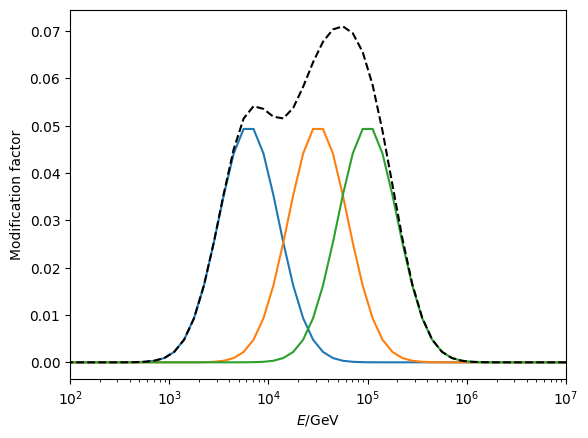

In [13]:
plt.plot(E,a_values)
plt.plot(E,b_values)
plt.plot(E,c_values)
plt.plot(E,a_values+b_values+c_values,color='black',ls='--')
plt.xscale('log')
plt.xlim(1.e2,1.e7)
plt.xlabel('$E$/GeV')
plt.ylabel('Modification factor')
#plt.ylim(0.99,1.1)

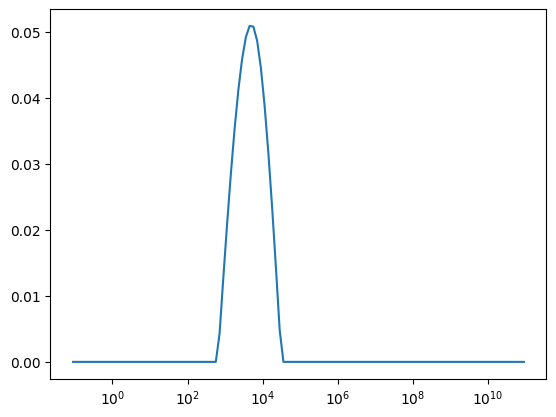

In [14]:
from scipy.interpolate import CubicSpline

knots = [2.8, np.log10(Ea),np.log10(Eb)]  # log10(E) positions
values = [0.0, a, 0.0]

cs = CubicSpline(knots, values, bc_type='natural')

bump = cs(np.log10(E))
bump[np.log10(E) < knots[0]] = 0.0
bump[np.log10(E) > knots[-1]] = 0.0

plt.plot(E, bump)
plt.xscale('log')

In [15]:
def spline_intp(E, Ek_1, Ek_c, E_k2, factor):
    knots = [np.log10(Ek_1), np.log10(Ek_c),np.log10(E_k2)]  # log10(E) positions
    values = [0.0, factor, 0.0]

    cs = CubicSpline(knots, values, bc_type='natural')

    bump = cs(np.log10(E))
    bump[np.log10(E) < knots[0]] = 0.0
    bump[np.log10(E) > knots[-1]] = 0.0
    return bump

In [16]:
spacing = (np.log10(1e6) - np.log10(800)) / 4

Ea = 800 * 10**spacing
Eb = Ea * 10**spacing
Ec = Eb * 10**spacing


spline_vals_a = spline_intp(E, 800, Ea, Eb, a)
spline_vals_b = spline_intp(E, Ea, Eb, Ec, a)
spline_vals_c = spline_intp(E, Eb, Ec, 1.e6, a)


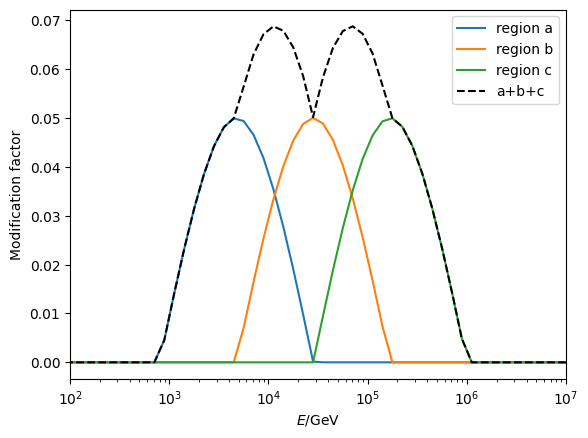

In [17]:
plt.plot(E, spline_vals_a,label='region a')
plt.plot(E, spline_vals_b,label='region b')
plt.plot(E, spline_vals_c,label='region c')
plt.plot(E, spline_vals_a+spline_vals_b+spline_vals_c,color='black',ls='--',label='a+b+c')
plt.xscale('log')
plt.xlim(1.e2,1.e7)
plt.ylabel('Modification factor')
plt.xlabel('$E$/GeV')
plt.legend()

In [18]:
# 1 spline with 3 different scaling knots



import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

def evaluate_spline(e_grid, p0, p1, p2):
    """
    Evaluate a cubic spline with 5 knots (outer knots fixed to zero).

    Parameters
    ----------
    e_grid : array-like
        Points at which to evaluate the spline.
    p0, p1, p2 : float
        Function values at the three interior knots.

    Notes
    -----
    - The spline has 5 knots in total:
        * Outer knots: y = 0 at x = min(e_grid) and x = max(e_grid)
        * Interior knots: y = p0, p1, p2 at equally spaced positions
        between the outer limits.
    - Uses `scipy.interpolate.CubicSpline` with natural boundary conditions.
    """
    e_grid = np.asarray(e_grid)
    assert np.all(e_grid > 0), "e_grid must be strictly positive."

    # Define knots between log10(1e3) and log10(1e6)
    log_e_knots = np.linspace(np.log10(1e3), np.log10(1e6), 5)
    y_knots = np.array([0.0, p0, p1, p2, 0.0])
    cs = CubicSpline(log_e_knots, y_knots, bc_type='natural')

    log_e = np.log10(e_grid)

    # Initialize result as zero
    result = np.zeros_like(e_grid)

    # Mask for values inside the knot range
    mask = (log_e >= log_e_knots[0]) & (log_e <= log_e_knots[-1])
    result[mask] = cs(log_e[mask])

    return result

In [19]:
def evaluate_spline(e_grid, p0, p1, p2):
    """
    Evaluate a cubic spline with 5 knots (outer knots fixed to zero).

    Parameters
    ----------
    e_grid : array-like
        Points at which to evaluate the spline.
    p0, p1, p2 : float
        Function values at the three interior knots.

    Notes
    -----
    - The spline has 5 knots in total:
        * Outer knots: y = 0 at x = min(e_grid) and x = max(e_grid)
        * Interior knots: y = p0, p1, p2 at equally spaced positions
        between the outer limits.
    - Uses `scipy.interpolate.CubicSpline` with natural boundary conditions.
    """
    e_grid = np.asarray(e_grid)
    assert np.all(e_grid > 0), "e_grid must be strictly positive."
    emin, emax = e_grid.min(), e_grid.max()
    log_e = np.log10(e_grid)
  

    # Define knots between log10(1e3) and log10(1e6)
    log_e_knots = np.linspace(np.log10(1e3), np.log10(1e6), 3)

    x_knots = np.concatenate([[np.log10(emin)],[np.log10(1e0)],[np.log10(5.e2)],log_e_knots,[np.log10(5.e6)],[np.log10(1e8)],[np.log10(emax)]])
    y_knots = np.array([0.0, 0.0, 0.0,  p0, p1, p2, 0.0, 0.0, 0.0])
    cs = CubicSpline(x_knots, y_knots, bc_type='natural')

    result = np.zeros_like(e_grid)  # Set everything to 0 by default
    mask = (e_grid >= 1.e3) & (e_grid <= 1.e6)
    result[mask] = cs(log_e[mask])
    
    return result

In [20]:
y_vals_onespline = evaluate_spline(E, 0.05, 0.05, 0.05)

In [21]:
y_vals_onespline

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.05667799, 0.06758042, 0.07547614, 0.08068273,
       0.08351779, 0.08429892, 0.08334371, 0.08096975, 0.07749465,
       0.073236  , 0.06851139, 0.06363843, 0.0589347 , 0.0547178 ,
       0.05130533, 0.04900421, 0.04787587, 0.04773625, 0.04839062,
       0.04964425, 0.0513024 , 0.05317034, 0.05505334, 0.05675667,
       0.05808559, 0.05884537, 0.05884128, 0.05787858, 0.05576254,
       0.05229843, 0.        , 0.        , 0.        , 0.     

/tmp/ipykernel_158015/4266426474.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


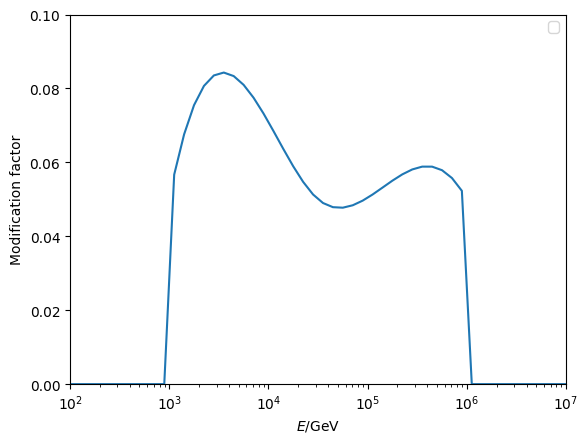

In [22]:
plt.plot(E, y_vals_onespline,)
plt.xscale('log')
plt.xlim(1.e2,1.e7)
plt.ylim(0.,0.1)
plt.ylabel('Modification factor')
plt.xlabel('$E$/GeV')
plt.legend()

In [23]:
from scipy.interpolate import make_interp_spline

def evaluate_noncubicspline(e_grid, p0, p1, p2):
    """
    Evaluate a cubic spline with 5 knots (outer knots fixed to zero).

    Parameters
    ----------
    e_grid : array-like
        Points at which to evaluate the spline.
    p0, p1, p2 : float
        Function values at the three interior knots.

    Notes
    -----
    - The spline has 5 knots in total:
        * Outer knots: y = 0 at x = min(e_grid) and x = max(e_grid)
        * Interior knots: y = p0, p1, p2 at equally spaced positions
        between the outer limits.
    - Uses `scipy.interpolate.CubicSpline` with natural boundary conditions.
    """
    e_grid = np.asarray(e_grid)
    assert np.all(e_grid > 0), "e_grid must be strictly positive."

    # Define knots between log10(1e3) and log10(1e6)
    x_knots = np.linspace(np.log10(3e2), np.log10(1e7), 5)
    y_knots = np.array([0.0, p0, p1, p2, 0.0])
    cs =  make_interp_spline(x_knots, y_knots, k=2)
    log_e = np.log10(e_grid)

    # Initialize result as zero
    result = np.zeros_like(e_grid)

    # Mask for values inside the knot range
    mask = (log_e >= x_knots[0]) & (log_e <= x_knots[-1])
    result[mask] = cs(log_e[mask])

    return result


In [30]:

def evaluate_noncubicspline(e_grid, p0, p1, p2):
    """
    Evaluate a cubic spline with 5 knots (outer knots fixed to zero).

    Parameters
    ----------
    e_grid : array-like
        Points at which to evaluate the spline.
    p0, p1, p2 : float
        Function values at the three interior knots.

    Notes
    -----
    - The spline has 5 knots in total:
        * Outer knots: y = 0 at x = min(e_grid) and x = max(e_grid)
        * Interior knots: y = p0, p1, p2 at equally spaced positions
        between the outer limits.
    - Uses `scipy.interpolate.CubicSpline` with natural boundary conditions.
    """
    e_grid = np.asarray(e_grid)
    assert np.all(e_grid > 0), "e_grid must be strictly positive."

    # Define knots between log10(1e3) and log10(1e6)
    x_knots_lin = np.linspace(np.log10(1.e3), np.log10(1e7), 4)
    x_knots = np.concatenate([[np.log10(5.e2)],x_knots_lin])
    y_knots = np.array([0.0, p0, p1, p2, 0.0])
    cs =  make_interp_spline(x_knots, y_knots, k=3)
    log_e = np.log10(e_grid)

    # Initialize result as zero
    #result = np.zeros_like(e_grid)

    # Mask for values inside the knot range
    #mask = (log_e >= x_knots[0]) & (log_e <= x_knots[-1])
    #result[mask] = cs(log_e[mask])

    return cs(log_e)#result


In [44]:
def evaluate_cubicspline(e_grid, p0, p1, p2):
    """
    Evaluate a cubic spline with 5 knots (outer knots fixed to zero).

    Parameters
    ----------
    e_grid : array-like
        Points at which to evaluate the spline.
    p0, p1, p2 : float
        Function values at the three interior knots.

    Notes
    -----
    - The spline has 5 knots in total:
        * Outer knots: y = 0 at x = min(e_grid) and x = max(e_grid)
        * Interior knots: y = p0, p1, p2 at equally spaced positions
        between the outer limits.
    - Uses `scipy.interpolate.CubicSpline` with natural boundary conditions.
    """
    e_grid = np.asarray(e_grid)
    assert np.all(e_grid > 0), "e_grid must be strictly positive."
    emin, emax = e_grid.min(), e_grid.max()

    # Define knots between log10(1e3) and log10(1e6)
    #x_knots = np.linspace(np.log10(emin), np.log10(emax), 9)
    x_knots = np.array([np.log10(emin), 0, 2, 2.5, 3, 4.5,  6, 7, 9, np.log10(emax)])
    y_knots = np.array([0.0, 0.0, 0.0, 0.0,  p0, p1, p2, 0.0, 0.0,0.0])
    cs =  make_interp_spline(x_knots, y_knots, k=2)
    log_e = np.log10(e_grid)

    # Initialize result as zero
    result = np.zeros_like(e_grid)

    # Mask for values inside the knot range
    mask = (log_e >= x_knots[0]) & (log_e <= x_knots[-1])
    result[mask] = cs(log_e[mask])

    return result

/tmp/ipykernel_158015/4003082074.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


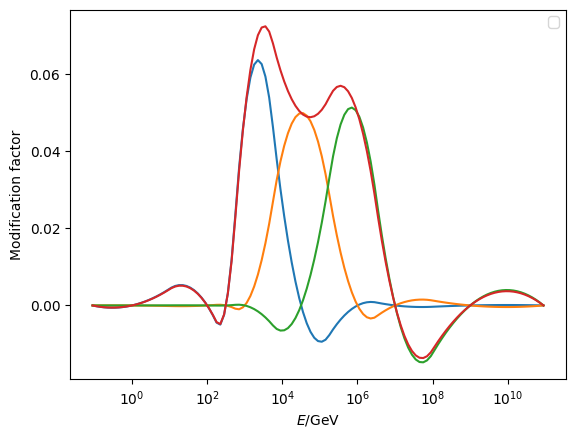

In [50]:
a = 0.05
b = 0.0
c = 0.0
x_knots = np.linspace(np.log10(3e2), np.log10(1e7), 5)


plt.plot(E, evaluate_cubicspline(E, a, 0, 0))
plt.plot(E, evaluate_cubicspline(E, 0, a, 0))
plt.plot(E, evaluate_cubicspline(E, 0, 0, a))
plt.plot(E, evaluate_cubicspline(E, a, 0, 0)+ evaluate_cubicspline(E, 0, a, 0) +  evaluate_cubicspline(E, 0, 0, a))

plt.xscale('log')
#plt.xlim(1.e2,1.e7)
#plt.ylim(0.,0.1)
plt.ylabel('Modification factor')
plt.xlabel('$E$/GeV')
plt.legend()

In [28]:
def evaluate_noncubicspline(e_grid, p0, p1, p2):
    """
    Evaluate a cubic spline with 5 knots (outer knots fixed to zero).

    Parameters
    ----------
    e_grid : array-like
        Points at which to evaluate the spline.
    p0, p1, p2 : float
        Function values at the three interior knots.

    Notes
    -----
    - The spline has 5 knots in total:
        * Outer knots: y = 0 at x = min(e_grid) and x = max(e_grid)
        * Interior knots: y = p0, p1, p2 at equally spaced positions
        between the outer limits.
    - Uses `scipy.interpolate.CubicSpline` with natural boundary conditions.
    """
    e_grid = np.asarray(e_grid)
    assert np.all(e_grid > 0), "e_grid must be strictly positive."
    emin, emax = e_grid.min(), e_grid.max()
  

    # Define knots between log10(1e3) and log10(1e6)
    log_e_knots = np.linspace(np.log10(1e3), np.log10(1e6), 3)

    x_knots = np.concatenate([[np.log10(emin)],[np.log10(1.e2)],log_e_knots,[np.log10(1.e7)],[np.log10(emax)]])
    y_knots = np.array([0.0, 0.0,  p0, p1, p2, 0.0, 0.0])
    cs =  make_interp_spline(x_knots, y_knots, k=2)
    log_e = np.log10(e_grid)

    #result = np.zeros_like(e_grid)  # Set everything to 0 by default
    #mask = (e_grid >= emin) & (e_grid <= emax)
    #result[mask] = cs(log_e[mask])
    
    return cs(log_e)#result

/tmp/ipykernel_158015/659810240.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


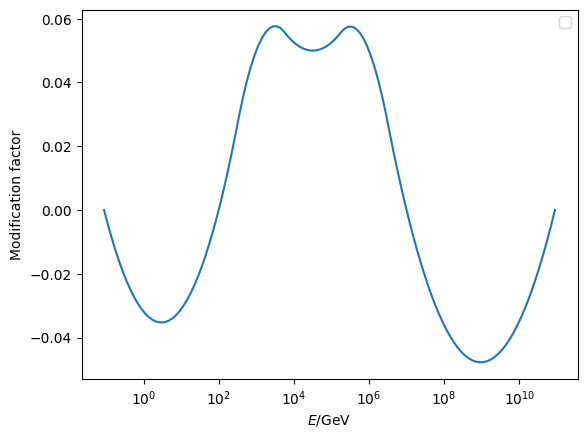

In [29]:
a = 0.05
b = 0.05
c = 0.05

y_vals_noncubicspline = evaluate_noncubicspline(E, 0.05, 0.05, 0.05)

plt.plot(E, y_vals_noncubicspline,)
plt.xscale('log')
#plt.xlim(1.e2,1.e7)
#plt.ylim(-0.01,0.1)
plt.ylabel('Modification factor')
plt.xlabel('$E$/GeV')
plt.legend()

In [51]:
from scipy.interpolate import BSpline

In [56]:
def b_spline_modification(e_grid, p0, p1, p2, emin=1e3, emax=1e6):
    # Define spline order (quadratic: k=2 means C1 continuous)
    k = 2

    # Define 3 internal knots in log space
    x_internal = np.linspace(np.log10(emin), np.log10(emax), 3)

    # Add boundary knots with multiplicity k+1
    # Total knots = len(x_internal) + 2*(k+1) = 3 + 6 = 9
    t = np.concatenate((
        [x_internal[0]] * (k + 1),
        x_internal,
        [x_internal[-1]] * (k + 1)
    ))

    # Coefficients (len = len(t) - k - 1 = 9 - 2 - 1 = 6)
    # Let the outer ones be 0 → natural decay
    c = np.array([0.0, p0, p1, p2, 0.0, 0.0])

    # Construct spline in log10(E)
    spline = BSpline(t, c, k)

    log_e = np.log10(e_grid)
    return spline(log_e)

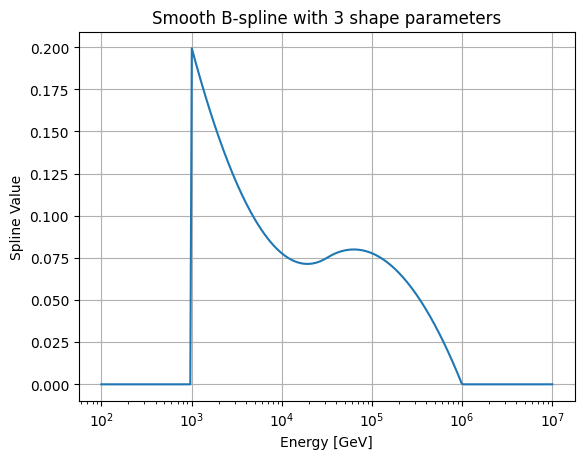

In [57]:
e_grid = np.logspace(2, 7, 300)  # 1e2 to 1e7 GeV
y = b_spline_modification(e_grid, 0.2, 0.05, 0.1)

plt.figure()
plt.semilogx(e_grid, y)
plt.xlabel("Energy [GeV]")
plt.ylabel("Spline Value")
plt.grid(True)
plt.title("Smooth B-spline with 3 shape parameters")
plt.show()

In [8]:
from scipy.interpolate import splrep,splev

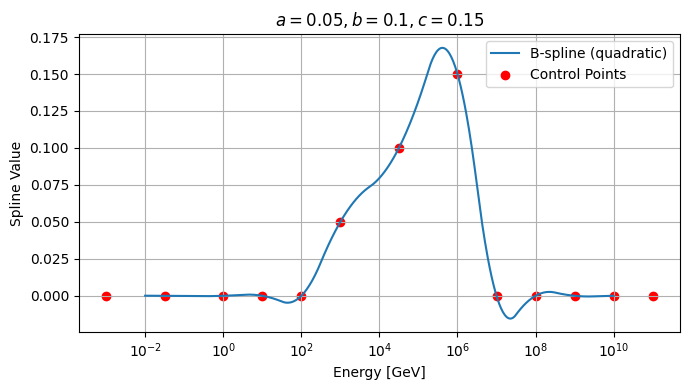

In [9]:
e_grid = np.logspace(-2, 10, 500)  # Energy from 1e2 to 1e7 GeV
log_e_grid = np.log10(e_grid)

# Define 3 control points (in log10(E))
x_knots = np.array([-3, -1.5, 0., 1., 2., 3.0, 4.5, 6.0,7.,8., 9., 10., 11])         # log10(E) values (e.g. 1e3, 3e4, 1e6)
y_knots = np.array([0., 0., 0.,0., 0.,0.05, 0.1, 0.15,0., 0., 0., 0., 0.])        # Values at the control points

# Fit a quadratic B-spline (k=2), with s=0 to interpolate exactly
tck = splrep(x_knots, y_knots, k=2, s=0)

# Evaluate the spline at all grid points
y_spline = splev(log_e_grid, tck)

# Plot
plt.figure(figsize=(7, 4))
plt.plot(e_grid, y_spline, label='B-spline (quadratic)')
plt.scatter(10**x_knots, y_knots, color='red', label='Control Points')
plt.xscale('log')
plt.xlabel('Energy [GeV]')
plt.ylabel('Spline Value')
plt.title('$a= 0.05, b=0.1, c=0.15$')
plt.grid(True)
plt.legend()
plt.tight_layout()


In [10]:
# function for spline

def bspline(e_grid, a, b ,c):
    log_e_grid = np.log10(e_grid)

    # Define 3 control points (in log10(E))
    x_knots = np.array([-3, -1.5, 0., 1., 2., 3.0, 4.5, 6.0,7.,8., 9., 10., 11])         # log10(E) values (e.g. 1e3, 3e4, 1e6)
    y_knots = np.array([0., 0., 0.,0., 0., a, b, c ,0., 0., 0., 0., 0.])        # Values at the control points

    # Fit a quadratic B-spline (k=2), with s=0 to interpolate exactly
    tck = splrep(x_knots, y_knots, k=2, s=0)

    # Evaluate the spline at all grid points
    y_spline = splev(log_e_grid, tck)

    return y_spline


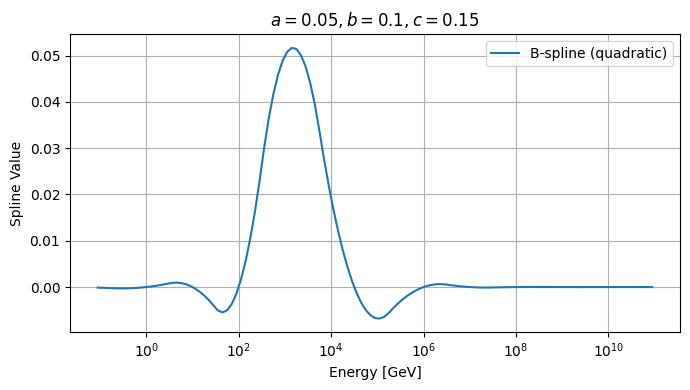

In [15]:
y_spline = bspline(E,0.05,0.0,0.)

# Plot
plt.figure(figsize=(7, 4))
plt.plot(E, y_spline, label='B-spline (quadratic)')
#plt.scatter(10**x_knots, y_knots, color='red', label='Control Points')
plt.xscale('log')
plt.xlabel('Energy [GeV]')
plt.ylabel('Spline Value')
plt.title('$a= 0.05, b=0.1, c=0.15$')
plt.grid(True)
plt.legend()
plt.tight_layout()


In [1]:
# investigate cross section modification in MCEq

mod_factor = 

SyntaxError: invalid syntax (4288633521.py, line 3)